In [31]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from inference_attack import *
from model import *

In [ ]:
# Configuration
model = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng_seed = 0
dataset_name = "MNIST"                         # "MNIST" or "CIFAR10"
data_path = "./data"

# Part 1 Use pretrained model to create a dataset for gradient classification
pretrained_model_path = "trained_model_MNIST.pth"
criterion_pretrained_model = torch.nn.CrossEntropyLoss()
num_classes = 10
inference_dataset_size = 500
batch_size_pretrained_model = 2

# Part 2 Train gradient classifier on gradient dataset
learning_rate_gradient_classifier = 0.001
criterion_grad_classifier = kl_div
train_size = 0.7
test_size = 1 - train_size
num_epochs = 10
batch_size_gradient_classifier = 16

# Part 3 Make inference on estimated gradient update
target_model_path = "GS_target_1.pth"
learning_rate_pretrained_model = 0.01
num_clients_fl = 10

In [33]:
# Make reproducible
random.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

## Part 1. Use pretrained model to create a dataset for gradient classification

In [34]:
# load dataset (we use test datasets to train the model on samples that have not been used in training of the global model)
if dataset_name == "MNIST":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)
    input_shape = (1, 28, 28)

elif dataset_name == "CIFAR10":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    dataset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
    input_shape = (3, 32, 32)

else:
    raise ValueError(f"Unsupported dataset: {dataset_name}")

indices = random.sample(range(len(dataset)), inference_dataset_size)
dataset = Subset(dataset, indices=indices)

dataloader = DataLoader(dataset, batch_size=batch_size_pretrained_model, shuffle=False)

In [35]:
# load pretrained model
theta_0 = torch.load(pretrained_model_path)

if model == 1:
    inference_model = Model1(input_shape, num_classes).to(device)
elif model == 2:
    inference_model = Model2(input_shape, num_classes).to(device)
else:
    print('Unknown model:', model)

inference_model.load_state_dict(state_dict=theta_0)

<All keys matched successfully>

In [36]:
# collect gradient features
features = []
labels = []

inference_model.to(device)
inference_model.train() # eval can make some layers behave differently (Not in our case)

for x, y in dataloader:
    x, y = x.to(device), y.to(device)

    # Forward pass
    output = inference_model(x)
    loss = criterion_pretrained_model(output, y)

    # Compute gradients w.r.t. model parameters (except fc)
    fc_params = set(p for p in inference_model.fc.parameters())
    all_params = list(inference_model.parameters())
    params_except_fc = [p for p in all_params if p not in fc_params]
    grad = torch.autograd.grad(loss, params_except_fc, retain_graph=False)
    # grad = torch.autograd.grad(loss, inference_model.parameters(), retain_graph=False)
    grad_vector = torch.cat([g.view(-1) for g in grad])  # Flatten and concatenate

    # Detach and store
    features.append(grad_vector.detach().cpu().float())
    labels.append(multi_hot_encode(y, num_classes))

features = torch.stack(features)
labels = torch.stack(labels).float()

dataset = TensorDataset(features, labels)
input_dim = features.shape[1]
output_dim = labels.shape[1]

## Part 2. Train gradient classifier on gradient dataset

In [37]:
# dataset split
tmp_train = int(train_size*inference_dataset_size/batch_size_pretrained_model)
tmp_test = int(inference_dataset_size/batch_size_pretrained_model-tmp_train)
print(tmp_train, tmp_test)

train_dataset, test_dataset = random_split(dataset, [tmp_train, tmp_test])

train_loader = DataLoader(train_dataset, batch_size=batch_size_gradient_classifier, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_gradient_classifier)

175 75


In [38]:
# Model training
grad_classifier_model = GradientClassifier(input_dim=input_dim, output_dim=output_dim)
grad_classifier_model.to(device)

train_grad_classifier(grad_classifier_model, train_loader, test_loader, criterion_grad_classifier, num_epochs=num_epochs, lr=learning_rate_gradient_classifier, device=device)

Epoch 1/10 | Loss: 4.4018 | Accuracy: 0.00%
Test Loss: 4.4331 | Cosine Similarity: 0.4804
Epoch 2/10 | Loss: 4.3495 | Accuracy: 0.00%
Test Loss: 4.3466 | Cosine Similarity: 0.6351
Epoch 3/10 | Loss: 4.1464 | Accuracy: 0.00%
Test Loss: 4.0997 | Cosine Similarity: 0.7510
Epoch 4/10 | Loss: 3.8823 | Accuracy: 0.00%
Test Loss: 3.8696 | Cosine Similarity: 0.7621
Epoch 5/10 | Loss: 3.7541 | Accuracy: 0.00%
Test Loss: 3.7849 | Cosine Similarity: 0.7941
Epoch 6/10 | Loss: 3.7233 | Accuracy: 0.00%
Test Loss: 3.7624 | Cosine Similarity: 0.7966
Epoch 7/10 | Loss: 3.7060 | Accuracy: 0.00%
Test Loss: 3.7572 | Cosine Similarity: 0.7941
Epoch 8/10 | Loss: 3.6940 | Accuracy: 0.00%
Test Loss: 3.7550 | Cosine Similarity: 0.8064
Epoch 9/10 | Loss: 3.6868 | Accuracy: 0.00%
Test Loss: 3.7509 | Cosine Similarity: 0.8136
Epoch 10/10 | Loss: 3.6812 | Accuracy: 0.00%
Test Loss: 3.7427 | Cosine Similarity: 0.8299


In [39]:
# Model evaluation
test_preds = evaluate_model(grad_classifier_model, test_loader, criterion_grad_classifier, device)

Test Loss: 3.7427 | Cosine Similarity: 0.8299


## Part 3. Make inference on estimated gradient update

In [43]:
# load true gradient update
true_grad = torch.load('DEBUG_true_grads.pth')
# remove fc layer
true_grad = remove_layers(true_grad, ['fc.weight', 'fc.bias'])

In [44]:
# Estimate gradient update
theta_0 = torch.load(pretrained_model_path)
theta_1 = torch.load(target_model_path)
# remove fc layer
theta_0 = remove_layers(theta_0, ['fc.weight', 'fc.bias'])
theta_1 = remove_layers(theta_1, ['fc.weight', 'fc.bias'])
# 
theta_1 = state_dict_scale(theta_1, num_clients_fl)
est_grad = estimate_gradient(theta_0, theta_1, learning_rate_pretrained_model)

cs = state_dicts_average_cosine_similarity(est_grad, true_grad)
mse = state_dicts_mse(est_grad, true_grad)
print(f'cosine similarity between estimated gradient and true gradient: {cs:.4f}')
print(f'mse between estimated gradient and true gradient: {mse:.4f}')

cosine similarity between estimated gradient and true gradient: -0.1768
mse between estimated gradient and true gradient: 0.0000


[0.00020806053362321109, 0.0011453658808022738, 0.00021091519738547504, 0.00011163038288941607, 0.0034748497419059277, 0.0007314719841815531, 0.0005469466559588909, 0.00016796666022855788, 0.00030751232407055795, 0.9930952191352844]


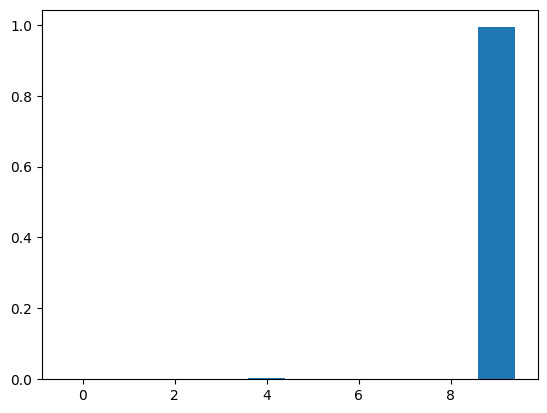

In [45]:
# Inference
est_grad_vector = torch.cat([est_grad[key].view(-1) for key in est_grad.keys()]).unsqueeze(0)
inferred = grad_classifier_model(est_grad_vector)
inferred = inferred.tolist()[0]
print(inferred)
plt.bar(range(num_classes), inferred)
plt.show()